### Импорт необходимых библиотек  и загрузка данных

### Colab logistic

In [1]:

from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/MyDrive/work/TSU/hh ru skillwords/job-description-keyword-extractor/notebooks
!pip install top2vec
!pip install top2vec[sentence_encoders]
!pip install top2vec[sentence_transformers]

Mounted at /content/drive
/content/drive/MyDrive/work/TSU/hh ru skillwords/job-description-keyword-extractor/notebooks
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 58.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp39-cp39-linux_x86_64.whl siz

In [2]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install top2vec[sentence_encoders]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Keyskils table creation

In [4]:
# import pandas as pd
# df = pd.read_csv('../data/data.csv')

# df = df[['key_skills']]

# df['key_skills'] = df['key_skills'].fillna('')
# df['key_skills'] = df['key_skills'].str.replace('{','').str.replace('}','').str.replace('"','')
# df['key_skills_list'] = df['key_skills'].str.split(',')
# df['key_skills'] = df['key_skills_list'].str.join(';')

# all_key_skills = []
# for key_skills in df['key_skills_list']:
#     all_key_skills+=key_skills
# all_key_skills = pd.Series(all_key_skills)

# all_key_skills_counts = all_key_skills.value_counts()

# all_key_skills_counts_df = pd.DataFrame()
# all_key_skills_counts_df['key_skill'] = all_key_skills_counts.index
# all_key_skills_counts_df['num'] = all_key_skills_counts.values
# all_key_skills_counts_df.to_csv('../data/all_key_skills_counts.csv', index = False)

In [4]:
#импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import multiprocessing as mp
from top2vec import Top2Vec
# import pymorphy2
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Table cleaning

In [26]:
#загрузка данных

df = pd.read_csv('../data/all_key_skills_counts.csv')
df = df.dropna()

,key_skill,num,topic
0,Работа в команде,273924,122
1,Грамотная речь,243882,196
2,Пользователь ПК,174906,1241
3,Активные продажи,135086,1233
4,Деловое общение,126952,619
...,...,...,...
94970,NET 5.0,1,426
94971,термическое оборудование,1,19
94972,испытательное оборудование,1,916
94973,Удаленки НЕТ!,1,1353


In [29]:
df = df[df['num']>2]

### Разведывательное исследование

### Этап 1: Предварительная обработка 

Рассмотрим базовую предварительную обработуку:
1. удаление лишних символов, включая ссылки - оставляем только буквенные;
2. приведение в нижний регистр;
3. удаление стоп-слов;
4. лемматизация (хотя она является опциональным критерием, так как предполагается встриваемая лемматизация алгоритма тематического моделирования)

Сразу сохраняем очищенные данные для того, чтобы не повторять процесс.

In [ ]:
from pymorphy2 import MorphAnalyzer
m = MorphAnalyzer()
mystopwords = stopwords.words('russian') 

# #мы отставляем в сообщениях только букувенные символы с помощью регулярных выражений и приводим текст в нижний регистр
# def words_only(text):
#     try:
#         text = re.sub('\\n', '', text)
#         text = re.sub('ht..{2,}?', '', text)
#         text = re.sub('\s+', ' ', text)
#         return re.findall("[А-Яа-я]+", text.lower())
#     except:
#         return []
    
# def lemmatize_word(token, pymorphy=m):
#     return pymorphy.parse(token)[0].normal_form

# def lemmatize_text(text):
#     return [lemmatize_word(w) for w in text]

# def remove_stopwords(lemmas, stopwords = mystopwords):
#     return [w for w in lemmas if not w in stopwords and len(w) > 3]

# def clean_text(text):
#     tokens = words_only(text)
#     lemmas = lemmatize_text(tokens)
    
#     return ' '.join(remove_stopwords(lemmas))

In [ ]:
%%time
with mp.Pool(mp.cpu_count()) as pool:
    preprocessed_text = list(tqdm(pool.map(clean_text, df['post_text']), total=len(df)))

In [ ]:
df['preprocessed_text'] = preprocessed_text   

In [ ]:
df.to_csv('preprocessed_text_wall_step1.csv')

### Этап 2: Очищение от городов

In [ ]:
# файл с городами
import json
filename = 'data/a.city.txt'
cities = json.load(open(filename, encoding="utf8"))

In [ ]:
regions1 = [item['name'] for item in cities]
cities = [item for sublist in cities for item in sublist['areas']]
regions2 = [item['name'] for item in cities]
cities = [item['name'] for sublist in cities for item in sublist['areas']]
cities += regions1+regions2
cities = [city. split(' (')[0] for city in cities]

In [ ]:
# создания правила, типа регулярок, но обрабатывающих падежи
#!pip install yargy

from yargy.pipelines import (
    morph_pipeline
)

from yargy import (
    Parser
)

RULE = morph_pipeline(cities)

city_parser = Parser(RULE)

In [ ]:
def filter_by_rule(line, parser, replace = ''):
    """Заменяет города на replace"""
    matches = list(parser.findall(line))[::-1]
    if len(matches)>0:
        start = matches[0].span.stop
        new_line = line[start:]
        for i in range(len(matches)):
            end = matches[i].span.start
            if len(matches)==i+1:
                start = 0
            else:
                start = matches[i+1].span.stop
                new_line = line[start:end]+replace+new_line
        return new_line
    else:
        return line

In [ ]:
%%time
# применение к данным
def filter_text(line):
    line = filter_by_rule(line, city_parser)
    return line

with mp.Pool(mp.cpu_count()) as pool:
    df['preprocessed_text_city'] = pool.map(filter_text, df['preprocessed_text'])

#df['preprocessed_text_city'] = df['preprocessed_text'].apply(filter_text)

CPU times: user 29.2 s, sys: 24.1 s, total: 53.3 s
Wall time: 5h 19min 10s


In [ ]:
df.to_csv('preprocessed_text_wall_2.csv') 

### Подготовка данных для обучения

In [ ]:
#удаление пропущенных значений 
# df.dropna(subset=['key_skill'], inplace = True)

In [30]:
docs = list(df.loc[:, "key_skill"].values) 

### Обучение и сохранение модели 

In [ ]:
import tensorflow as tf
#with tf.device('/device:GPU:0'):
with tf.device('/device:GPU:0'):
    model = Top2Vec(docs, 
                    min_count = 5,

                    embedding_model='universal-sentence-encoder-multilingual-large',
                    workers=mp.cpu_count())

2023-03-09 04:49:28,513 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2023-03-09 04:49:29,046 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual-large model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual-large model
2023-03-09 04:49:58,046 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-03-09 04:50:26,669 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


In [24]:
Top2Vec

top2vec.Top2Vec.Top2Vec

In [32]:
#получение количества тем
n = model.get_num_topics()

In [33]:
n

606

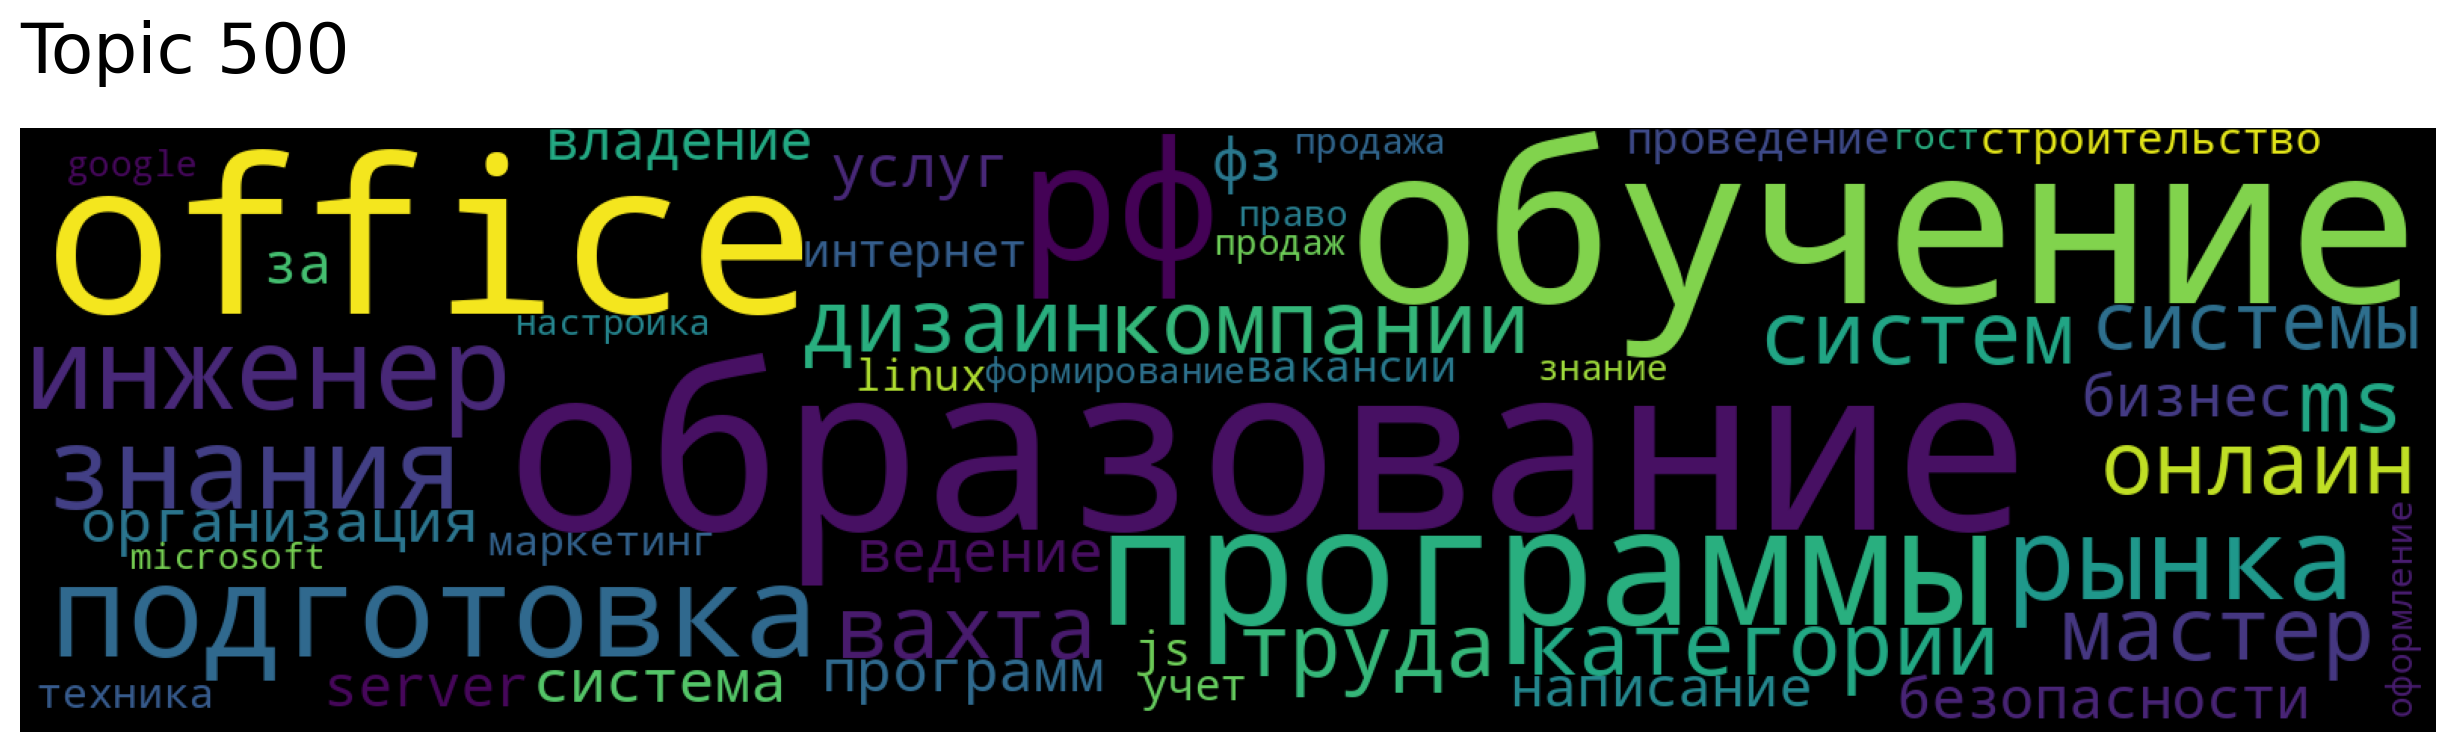

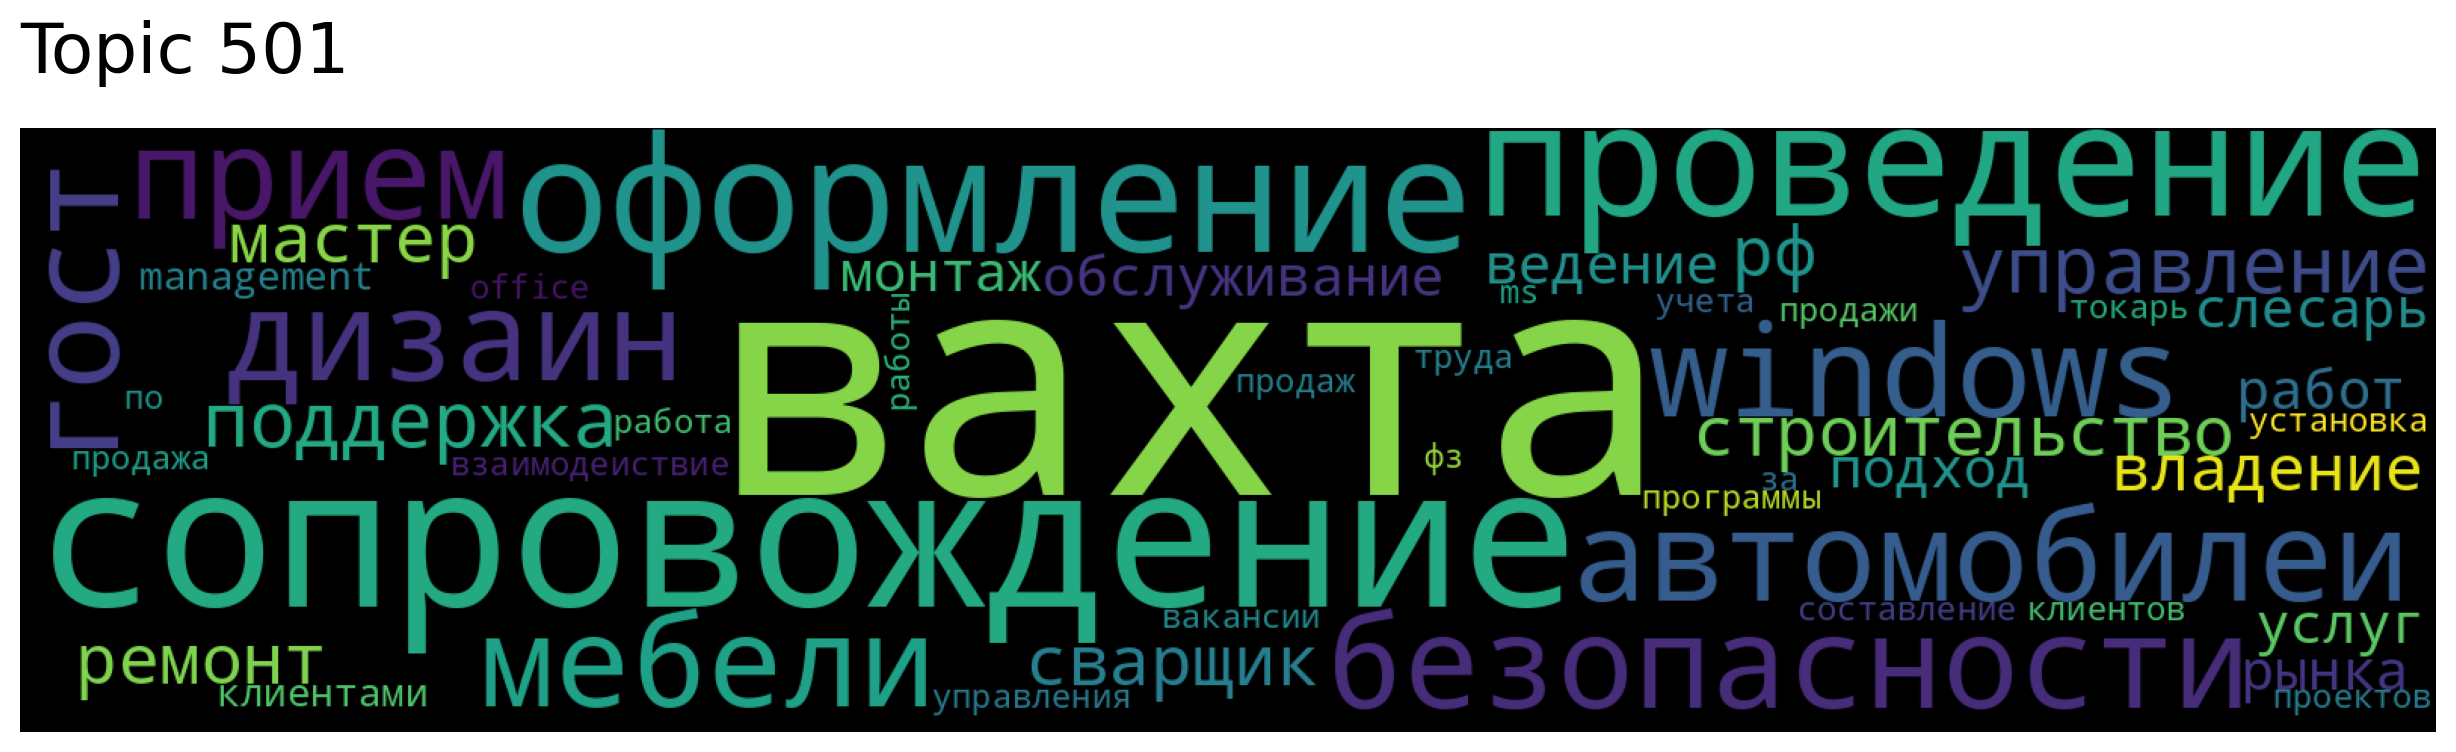

In [34]:
#облака слов по каждой теме
topic_words, word_scores, topic_nums = model.get_topics(n)
for topic in topic_nums[500:502]:
    model.generate_topic_wordcloud(topic)

In [12]:
#сохранение модели 
model.save("../models/top2vec_base")

In [14]:
#получение номеров топиков для постов
topic = model.doc_top
df['topic'] =  topic

In [21]:
df[df['topic']==1000]

,key_skill,num,topic
1405,Государственные структуры,802,1000
3194,Организационная структура,171,1000
5469,Самостоятельное построение ссылочной структуры,46,1000
5982,Разработка организационной структуры компании,37,1000
6841,Tekla Structures,28,1000
7758,Структурность,21,1000
11861,Структурные изменения,11,1000
12100,Дивизиональная структура,11,1000
17440,Стремление к структурному,6,1000
20123,Умение структурировать,5,1000


In [ ]:
#сохранение данных 
df.to_csv('topic_text.csv')

In [ ]:
!nvidia-smi